# 1. Data Load

In [76]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 
from pickle import dump

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [77]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

In [78]:
path = "./Dataset/"

data = pd.read_csv(path+"train.csv")

# original data -> data
data

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.00,5.00,5.00,5.00,1.00,4.00,5.00,5.00,1.00,...,1.00,20,2.00,12.00,4.00,2.00,1.00,4.00,2.00,1
1,1,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,3.00,...,1.00,49,1.00,2.00,1.00,1.00,2.00,4.00,2.00,1
2,2,4.00,5.00,5.00,4.00,3.00,5.00,5.00,5.00,4.00,...,2.00,43,1.00,2.00,2.00,2.00,3.00,4.00,2.00,1
3,3,4.00,4.00,4.00,2.00,4.00,3.00,3.00,5.00,3.00,...,1.00,17,2.00,1.00,1.00,2.00,1.00,2.00,2.00,1
4,4,4.00,4.00,4.00,4.00,3.00,3.00,4.00,2.00,3.00,...,2.00,18,2.00,12.00,1.00,2.00,1.00,1.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.00,5.00,4.00,3.00,3.00,4.00,4.00,4.00,3.00,...,1.00,17,1.00,1.00,3.00,2.00,1.00,3.00,2.00,0
14996,14996,5.00,4.00,5.00,4.00,4.00,5.00,5.00,4.00,4.00,...,2.00,45,1.00,3.00,1.00,1.00,2.00,3.00,2.00,1
14997,14997,4.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,...,1.00,20,1.00,1.00,2.00,1.00,1.00,3.00,1.00,1
14998,14998,5.00,5.00,4.00,5.00,5.00,5.00,5.00,1.00,5.00,...,1.00,29,1.00,12.00,4.00,2.00,2.00,2.00,1.00,0


# 2. EDA 

15,000 rows × 70 columns

- feature (1)
    - index 
- Categorical variable (63)
    - country : 137 values, not valanced 
    - education : 4 values 
    - urban : 4 values, but start with 0 
    - gender : 3 
    - engnat : 2 
    - hand : 3 
    - religion : 12 
    - orientation : 5
    - voted : 2
    - married : 3
    - ASD : 2 
    - Q(26) : 5 values
        - 1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree
    - TIPI(10) : 5 values 
        - items were rated "I see myself as:" _____ such that Extraverted, enthusiastic...
    - VCL(16) : 2 values (0 or 1) 
        - no more need for preprocessing
- Numerical variable (5)
    - introelapse : 1315 values 
    - testelapse : 684 values 
    - surveyelapse : 712 values
    - age : 76 values, but maybe outlier...
    - familysize : 20 values, but maybe outlier... 
- Y variable (1)
    - nerdiness 
        - binary classification 
        - 1:8303, 0:6697

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

<AxesSubplot:>

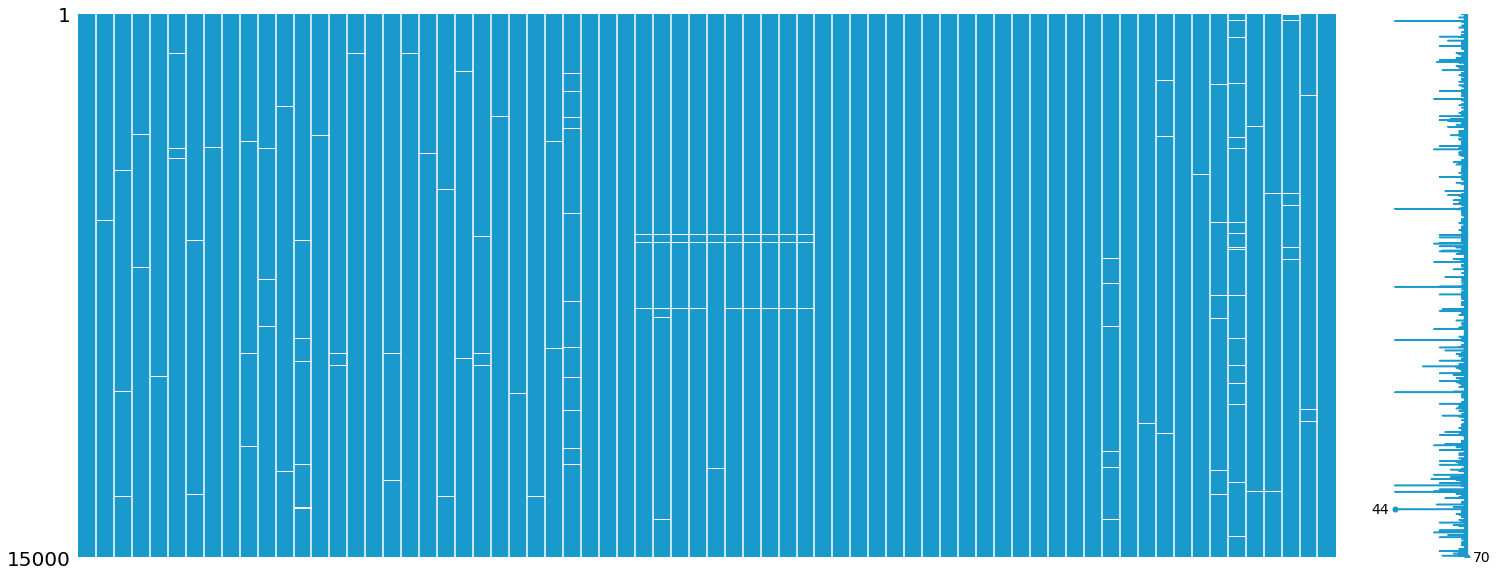

In [5]:
# missing value check
msno.matrix(data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 3. Preprocessing
data -> processed_data (**15,000 x 70 -> 15,000 x 50**)

Basic 
- **Drop unnecessary features** 
    - index, country(...)
- **Handling missing values (...)**
    - **fillna 0**
        - education, gender, hand, religion, orientation, voted, married, ASD
        - 무응답은 0으로 채우기 (urban은 이미 0부터 시작) 
    - **imputation : simple method**
        
Question (Q, TIPI, VCL)
- TIPI scoring to 'O', 'C', 'E', 'A', 'N' 
- VCL scoring (he words at **VCL6, VCL9, and VCL12** are not real words and can be used as a validity check)

    
Numerical
- **Log Transformation**
    - 3 elapse cols (intro, test, survey)
- **Ranging**
    - 'age' to 10 category (0~10/10~20..90~100)
- **Handling outlier**
    - 'familysize' to make np.Nan and imputate


In [79]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature drop 
# 'index', 'country'
processed_data = data.drop(['index', 'country'], axis=1).copy()

In [80]:
# Handling missing values with simple imputator
# 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer

fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'nerdiness']
transformer = SimpleImputer()
processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
processed_data[fill_cols].describe()

,education,gender,engnat,hand,religion,orientation,voted,married,ASD,nerdiness
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,2.31,1.70,1.35,1.19,4.10,1.85,1.63,1.18,1.94,0.55
std,0.92,0.55,0.47,0.48,3.40,1.21,0.48,0.46,0.24,0.50
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
25%,2.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,2.00,0.00
50%,2.00,2.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,1.00
75%,3.00,2.00,2.00,1.00,6.00,2.00,2.00,1.00,2.00,1.00
max,4.00,3.00,2.00,3.00,12.00,5.00,2.00,3.00,2.00,1.00


In [ ]:
# Lable Encoding : 'country' 
from sklearn.preprocessing import LabelEncoder

# labeling the other countries as 1 
df_country = pd.DataFrame(data['country'].value_counts())
others = df_country[df_country['country']==1].index.values.tolist()
processed_data['country'] = processed_data['country'].apply(lambda x : 1 if x in others else x)

le = LabelEncoder()
processed_data['country'] = le.fit_transform(list(processed_data['country']))   
print(le.classes_)

# save encoder
dump(le, open('labelencoder.pkl', 'wb'))

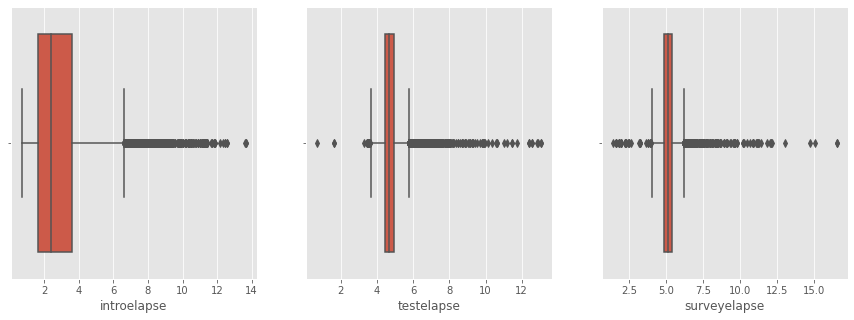

In [82]:
# Log Transformation
# 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# for checking 
plt.style.use("ggplot") 
plt.figure(figsize=(15,5))
    
for i in range(len(right_skewed_cols)):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=right_skewed_cols[i], data=processed_data)

In [83]:
# Ranging and Ordinary Encoding 
# 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)

oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data['age'].values.reshape(-1,1))
processed_data['age'].value_counts()

0.00    6824
1.00    5161
2.00    1493
3.00     822
4.00     459
5.00     202
6.00      28
9.00       7
7.00       3
8.00       1
Name: age, dtype: int64

count   15000.00
mean        2.30
std         0.84
min         1.00
25%         2.00
50%         2.00
75%         3.00
max         4.00
Name: familysize, dtype: float64


<AxesSubplot:xlabel='familysize'>

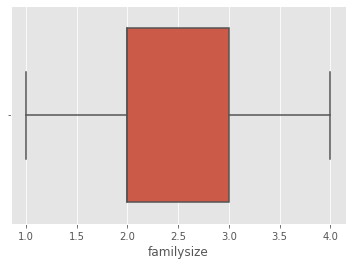

In [84]:
# Handling outlier
# 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize', 'nerdiness']] = transformer.fit_transform(processed_data[['familysize', 'nerdiness']])
print(processed_data['familysize'].describe())
sns.boxplot(x='familysize', data=processed_data)

<AxesSubplot:>

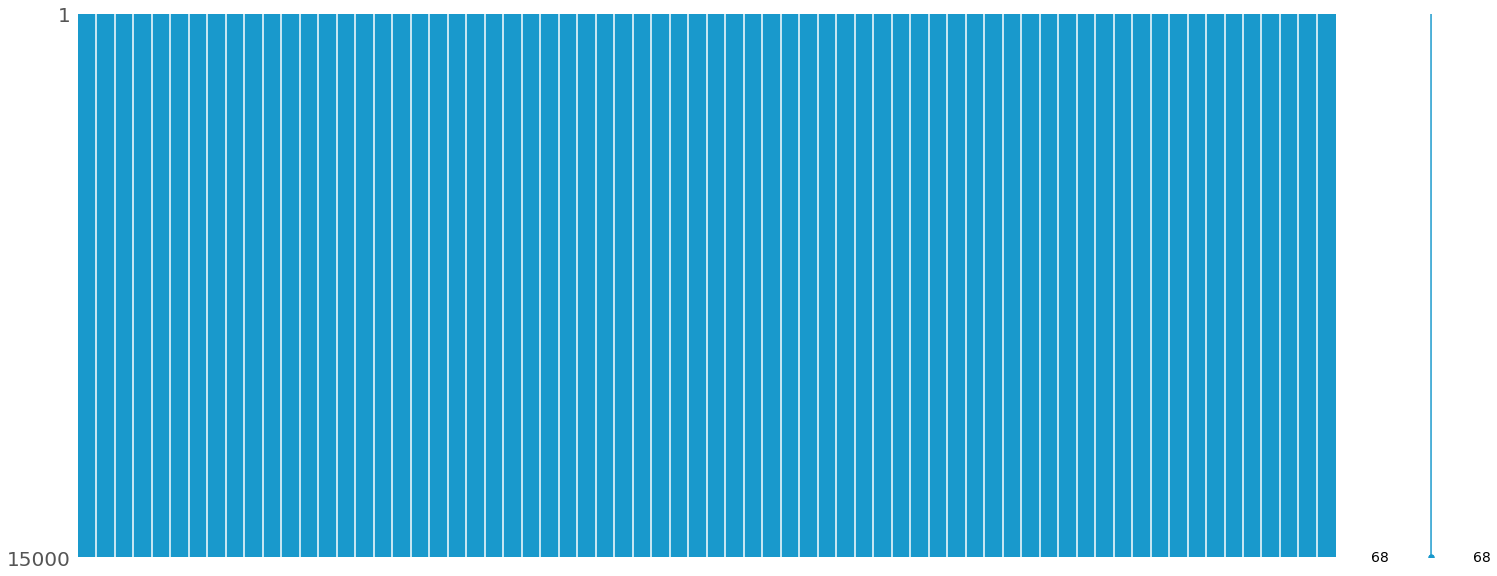

In [85]:
# finish handling missing values! 
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
q_cols = [npas_cols, tipi_cols, vcl_cols]

for col in q_cols : 
    transformer = SimpleImputer()
    processed_data[col] = transformer.fit_transform(processed_data[col])
    
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

the Nerdy Personality Attributes Scale

Your score was 30. Scores range from a low of 30 to a high of 70. The exact average score is 50. People who score higher on the NPAS are more likely to identify as nerds. Below is a graph of what percent of people say yes when asked the question "Are you a nerd?" based on what their NPAS score was.

http://openpsychometrics.org/tests/NPAS/development/

In [86]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

processed_data = score_mach(processed_data)
processed_data['Mach']

0       3.05
1       3.10
2       3.00
3       2.95
4       2.95
        ... 
14995   3.15
14996   2.80
14997   3.00
14998   2.65
14999   2.95
Name: Mach, Length: 15000, dtype: float64

TIPI scale scoring (“R” denotes reverse-scored items):



- Extraversion: 1, 6R; 

- Agreeableness: 2R, 7; 

- Conscientiousness; 3, 8R; 

- Emotional Stability: 4R, 9;

- Openness to Experiences: 5, 10R.

coring the TIPI

1. Recode the reverse-scored items (i.e., recode a 7 with a 1, a 6 with a 2, a 5 with a 3, etc.). The reverse scored items are 2, 4, 6, 8, & 10.

2. Take the AVERAGE of the two items (the standard item and the recoded reverse-scored item) that make up each scale.

Example using the Extraversion scale: A participant has scores of 5 on item 1 (Extraverted, enthusiastic) and and 2 on item 6 (Reserved, quiet). First, recode the reverse-scored item (i.e., item 6), replacing the 2 with a 6. Second, take the average of the score for item 1 and the (recoded) score for item 6. So the TIPI Extraversion scale score would be: (5 + 6)/2 = 5.5

https://gosling.psy.utexas.edu/scales-weve-developed/ten-item-personality-measure-tipi/

In [87]:
def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

processed_data = score_tipi(processed_data)
processed_data[['E', 'A', 'C', 'N', 'O']]

,E,A,C,N,O
0,3.50,5.00,5.00,6.00,4.00
1,5.00,5.50,5.00,2.50,4.50
2,2.00,4.50,3.50,6.00,5.50
3,4.00,4.50,3.50,3.50,5.00
4,3.50,4.00,4.00,3.50,5.00
...,...,...,...,...,...
14995,2.50,4.50,4.50,4.00,4.00
14996,4.00,5.00,5.50,2.50,5.00
14997,2.00,4.00,3.50,2.00,4.00
14998,2.00,6.00,3.50,2.50,5.50


VCL scale scoring

The following items were presented as a check-list and subjects were instructed "In the grid below, check all the words whose definitions you are sure you know":

A value of 1 is checked, 0 means unchecked. The words at VCL6, VCL9, and VCL12 are not real words and can be used as a validity check.

https://www.kaggle.com/datasets/lucasgreenwell/nerdy-personality-attributes-scale-responses

In [88]:
def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

processed_data = score_vcl(processed_data)
processed_data[['VCL_score', 'VCL_faker']]

,VCL_score,VCL_faker
0,8.00,0.00
1,11.00,0.00
2,11.00,0.00
3,9.00,0.00
4,8.00,0.00
...,...,...
14995,10.00,1.00
14996,8.00,0.00
14997,9.00,0.00
14998,11.00,1.00


# 4. Data Split 
split data as train/valid

In [103]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data_y = input_data['nerdiness'].copy()
input_data_X = input_data.drop(['nerdiness'], axis=1)

# train/ test data 로 split 
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 7,
    shuffle=True
)

train_data = pd.concat([train_X, train_y], axis=1).reset_index(drop=True)
test_data = pd.concat([test_X, test_y], axis=1).reset_index(drop=True)

# 5. AutoML 

using pycaret, autoML Library

In [20]:
from pycaret.classification import *
from time import time

In [104]:
# Setup Environment  
cat_cols = ['urban', 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'] + npas_cols
num_cols = ['introelapse', 'testelapse', 'surveyelapse', 'familysize', 'Mach', 'E', 'A', 'C', 'N', 'O', 'VCL_score', 'VCL_faker'] 
ord_cols = ['age'] 
ord_dict = {} 
for col in ord_cols :
    unique_list = input_data[col].unique()
    unique_list = sorted(unique_list[~pd.isnull(unique_list)])
    ord_dict[col] = unique_list

clf = setup(data = train_data, 
            #train_size = 0.8,
            test_data = test_data,
            target = 'nerdiness',
            categorical_features = cat_cols,
            numeric_features = num_cols,
            ordinal_features = ord_dict,
            high_cardinality_features = ['religion'],
            high_cardinality_method = 'frequency',
            handle_unknown_categorical = True,
            data_split_stratify = True,
            normalize = True,
            normalize_method = 'zscore', 
            feature_selection = True,
            imputation_type='simple',
            fold_shuffle=True,
            use_gpu = True,
            silent = True,
            session_id = 6315)

,Description,Value
0,session_id,6315
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(12000, 50)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,36
8,Ordinal Features,True
9,High Cardinality Features,True


## Comparing

In [175]:
# et, rf, cat, lgbm, gbc
top5 = compare_models(sort='AUC', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7668,0.8604,0.8202,0.7727,0.7957,0.5247,0.5262,1.8060
rf,Random Forest Classifier,0.7696,0.8568,0.8278,0.7725,0.7991,0.5298,0.5317,1.6380
catboost,CatBoost Classifier,0.7505,0.8260,0.8079,0.7576,0.7819,0.4912,0.4926,10.0900
lightgbm,Light Gradient Boosting Machine,0.7447,0.8179,0.8032,0.7523,0.7769,0.4792,0.4806,0.2680
gbc,Gradient Boosting Classifier,0.7326,0.8036,0.7931,0.7418,0.7665,0.4544,0.4559,6.7460
lr,Logistic Regression,0.7263,0.7958,0.7856,0.7372,0.7606,0.4419,0.4432,1.8280
lda,Linear Discriminant Analysis,0.7243,0.7945,0.7888,0.7333,0.7600,0.4372,0.4389,0.4540
ada,Ada Boost Classifier,0.7238,0.7939,0.7800,0.7365,0.7576,0.4371,0.4382,2.2440
nb,Naive Bayes,0.6973,0.7580,0.7734,0.7072,0.7388,0.3807,0.3829,0.1220
knn,K Neighbors Classifier,0.6698,0.7197,0.8162,0.6642,0.7323,0.3130,0.3246,2.9520


## Training top 5 models

In [105]:
total_models = []

In [106]:
cell_start_time = time()
model_et = create_model('et', fold = 10)
total_models.append(model_et)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7758,0.8595,0.8190,0.7847,0.8015,0.5443,0.5450
1,0.7775,0.8628,0.8281,0.7821,0.8044,0.5469,0.5481
2,0.7508,0.8475,0.7949,0.7638,0.7790,0.4937,0.4942
3,0.7758,0.8631,0.8250,0.7814,0.8026,0.5437,0.5448
4,0.7733,0.8642,0.8399,0.7701,0.8035,0.5369,0.5398
5,0.7700,0.8702,0.8218,0.7749,0.7977,0.5318,0.5330
6,0.7725,0.8680,0.8202,0.7791,0.7991,0.5373,0.5382
7,0.7658,0.8554,0.8172,0.7718,0.7938,0.5234,0.5245
8,0.7783,0.8669,0.8278,0.7829,0.8047,0.5489,0.5500
9,0.7708,0.8572,0.8338,0.7699,0.8006,0.5322,0.5346


CELL RUN TIME :  18.59754991531372


In [107]:
cell_start_time = time()
model_rf = create_model('rf', fold = 10)
total_models.append(model_rf)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7683,0.8577,0.8190,0.7746,0.7962,0.5283,0.5294
1,0.7767,0.8627,0.8281,0.7809,0.8038,0.5451,0.5464
2,0.7633,0.8514,0.8205,0.7673,0.7930,0.5175,0.5191
3,0.7742,0.8593,0.8341,0.7745,0.8032,0.5391,0.5412
4,0.7867,0.8696,0.8580,0.7781,0.8161,0.5636,0.5674
5,0.7725,0.8632,0.8142,0.7823,0.7979,0.5379,0.5385
6,0.7900,0.8708,0.8338,0.7954,0.8142,0.5731,0.5739
7,0.7617,0.8585,0.8142,0.7678,0.7903,0.5148,0.5160
8,0.7858,0.8706,0.8353,0.7889,0.8114,0.5641,0.5653
9,0.7792,0.8606,0.8474,0.7738,0.8089,0.5486,0.5518


CELL RUN TIME :  13.357617139816284


In [108]:
cell_start_time = time()
model_cat = create_model('catboost', fold = 10)
total_models.append(model_cat)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7808,0.8580,0.8190,0.7915,0.8050,0.5550,0.5554
1,0.7783,0.8566,0.8326,0.7808,0.8058,0.5482,0.5497
2,0.7583,0.8360,0.8039,0.7691,0.7861,0.5087,0.5093
3,0.7692,0.8492,0.8356,0.7673,0.8000,0.5283,0.5309
4,0.7600,0.8540,0.8353,0.7555,0.7934,0.5088,0.5125
5,0.7867,0.8622,0.8444,0.7851,0.8137,0.5649,0.5670
6,0.7683,0.8462,0.8202,0.7735,0.7962,0.5284,0.5296
7,0.7692,0.8492,0.8308,0.7692,0.7988,0.5290,0.5312
8,0.7783,0.8573,0.8308,0.7812,0.8053,0.5486,0.5500
9,0.7717,0.8484,0.8520,0.7622,0.8046,0.5321,0.5368


CELL RUN TIME :  77.98879837989807


In [109]:
cell_start_time = time()
model_lgbm = create_model('lightgbm', fold = 10)
total_models.append(model_lgbm)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7675,0.8460,0.8069,0.7799,0.7932,0.5279,0.5283
1,0.7767,0.8528,0.8326,0.7786,0.8047,0.5446,0.5463
2,0.7483,0.8289,0.7979,0.7590,0.7779,0.4880,0.4888
3,0.7792,0.8399,0.8431,0.7764,0.8084,0.5489,0.5515
4,0.7683,0.8478,0.8429,0.7623,0.8006,0.5259,0.5297
5,0.7725,0.8491,0.8278,0.7751,0.8006,0.5365,0.5380
6,0.7742,0.8423,0.8172,0.7829,0.7997,0.5411,0.5418
7,0.7642,0.8435,0.8112,0.7727,0.7915,0.5205,0.5213
8,0.7725,0.8544,0.8202,0.7791,0.7991,0.5373,0.5382
9,0.7558,0.8347,0.8338,0.7510,0.7903,0.5000,0.5040


CELL RUN TIME :  2.279965877532959


In [110]:
cell_start_time = time()
model_gbc = create_model('gbc', fold = 10)
total_models.append(model_gbc)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7500,0.8273,0.8009,0.7597,0.7797,0.4912,0.4921
1,0.7567,0.8306,0.8130,0.7624,0.7869,0.5040,0.5055
2,0.7300,0.8098,0.7934,0.7377,0.7645,0.4491,0.4507
3,0.7475,0.8180,0.8265,0.7446,0.7834,0.4827,0.4865
4,0.7558,0.8331,0.8338,0.7510,0.7903,0.5000,0.5040
5,0.7600,0.8352,0.8127,0.7664,0.7889,0.5114,0.5126
6,0.7458,0.8253,0.7991,0.7546,0.7762,0.4827,0.4837
7,0.7383,0.8261,0.8051,0.7423,0.7725,0.4658,0.4679
8,0.7392,0.8335,0.8051,0.7434,0.7730,0.4676,0.4697
9,0.7508,0.8240,0.8293,0.7469,0.7860,0.4898,0.4936


CELL RUN TIME :  55.39936685562134


## Tuninig Models 

In [111]:
model_et = tune_model(model_et, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7092,0.7810,0.8068,0.7075,0.7539,0.4022,0.4074
1,0.7008,0.7667,0.7955,0.7022,0.7459,0.3856,0.3901
2,0.7233,0.7902,0.8143,0.7208,0.7647,0.4320,0.4368
3,0.7292,0.7917,0.8204,0.7252,0.7698,0.4439,0.4489
4,0.7150,0.7836,0.8165,0.7102,0.7597,0.4137,0.4198
Mean,0.7155,0.7827,0.8107,0.7132,0.7588,0.4155,0.4206
SD,0.0100,0.0089,0.0088,0.0085,0.0083,0.0208,0.0208


In [112]:
model_rf = tune_model(model_rf, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7196,0.7842,0.8121,0.7173,0.7618,0.4242,0.4290
1,0.7075,0.7691,0.8045,0.7064,0.7523,0.3989,0.4039
2,0.7212,0.7931,0.8121,0.7193,0.7629,0.4278,0.4324
3,0.7250,0.7928,0.8121,0.7236,0.7653,0.4359,0.4402
4,0.7204,0.7851,0.8225,0.7141,0.7645,0.4247,0.4312
Mean,0.7188,0.7849,0.8127,0.7161,0.7613,0.4223,0.4273
SD,0.0059,0.0087,0.0057,0.0058,0.0047,0.0124,0.0123


In [113]:
model_cat = tune_model(model_cat, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7904,0.8645,0.8385,0.7936,0.8154,0.5734,0.5746
1,0.7775,0.8504,0.8385,0.7764,0.8062,0.5459,0.5481
2,0.7867,0.8637,0.8551,0.7798,0.8157,0.5638,0.5671
3,0.7771,0.8563,0.8302,0.7801,0.8044,0.5459,0.5473
4,0.7721,0.8576,0.8437,0.7666,0.8033,0.5339,0.5373
Mean,0.7808,0.8585,0.8412,0.7793,0.8090,0.5526,0.5549
SD,0.0067,0.0052,0.0082,0.0086,0.0054,0.0141,0.0138


In [114]:
model_lgbm = tune_model(model_lgbm, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7696,0.8522,0.8106,0.7805,0.7953,0.5320,0.5325
1,0.7696,0.8415,0.8181,0.7765,0.7968,0.5312,0.5322
2,0.7800,0.8532,0.8438,0.7769,0.8090,0.5507,0.5533
3,0.7662,0.8450,0.8174,0.7725,0.7943,0.5242,0.5253
4,0.7671,0.8447,0.8248,0.7696,0.7962,0.5252,0.5269
Mean,0.7705,0.8473,0.8229,0.7752,0.7983,0.5327,0.5340
SD,0.0049,0.0046,0.0114,0.0038,0.0054,0.0095,0.0100


In [115]:
model_gbc = tune_model(model_gbc, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7725,0.8472,0.8287,0.7749,0.8009,0.5363,0.5379
1,0.7629,0.8402,0.8211,0.7662,0.7927,0.5166,0.5183
2,0.7783,0.8538,0.8438,0.7748,0.8078,0.5471,0.5499
3,0.7608,0.8463,0.8128,0.7676,0.7896,0.5131,0.5142
4,0.7717,0.8496,0.8406,0.7676,0.8025,0.5333,0.5364
Mean,0.7692,0.8474,0.8294,0.7702,0.7987,0.5293,0.5313
SD,0.0065,0.0044,0.0116,0.0038,0.0066,0.0127,0.0132


In [116]:
tuned_models = [model_et, model_rf, model_cat, model_lgbm, model_gbc]

## Blending Models

In [117]:
blender_top5 = blend_models(estimator_list=tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7967,0.8772,0.8446,0.7989,0.8211,0.5860,0.5872
1,0.7975,0.8810,0.8492,0.7975,0.8225,0.5873,0.5889
2,0.7775,0.8639,0.8311,0.7805,0.8050,0.5466,0.5481
3,0.8025,0.8764,0.8688,0.7934,0.8294,0.5961,0.5996
4,0.7925,0.8777,0.8716,0.7787,0.8225,0.5747,0.5800
5,0.8025,0.8805,0.8550,0.8006,0.8269,0.5976,0.5993
6,0.8042,0.8743,0.8474,0.8072,0.8268,0.6018,0.6028
7,0.7892,0.8740,0.8429,0.7893,0.8152,0.5704,0.5721
8,0.7925,0.8820,0.8444,0.7929,0.8178,0.5774,0.5789
9,0.7867,0.8689,0.8535,0.7804,0.8153,0.5640,0.5672


In [ ]:
plot_model(blender_top5, plot='feature')

In [ ]:
plot_model(blender_top5, plot='auc')

## Prediction for Test data 

In [118]:
# for total models 
for model in total_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7947,0.8807,0.8374,0.8039,0.8203,0.5810,0.5817


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7977,0.8829,0.8422,0.8052,0.8233,0.5869,0.5877


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7863,0.8706,0.8279,0.7979,0.8126,0.5643,0.5648


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7817,0.8624,0.8213,0.7953,0.8081,0.5551,0.5554


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7680,0.8432,0.8100,0.7830,0.7963,0.5271,0.5275


In [119]:
# for tuned models 
for model in tuned_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7947,0.8807,0.8374,0.8039,0.8203,0.5810,0.5817


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7977,0.8829,0.8422,0.8052,0.8233,0.5869,0.5877


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8073,0.8848,0.8505,0.8137,0.8317,0.6067,0.6075


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7933,0.8736,0.8303,0.8062,0.8181,0.5790,0.5793


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7947,0.8734,0.8392,0.8028,0.8206,0.5808,0.5816


In [120]:
# for blended model 
prediction = predict_model(blender_top5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8183,0.8970,0.8547,0.8266,0.8404,0.6297,0.6302


# 6. Saving Models

In [121]:
final_model = blender_top5 # you should fill out this 

In [324]:
# makes overfitting!! 
final_model = finalize_model(blender_top5) # you should fill out this 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

In [122]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M")
filename = 'Pycaret_yesQ_test_'+filename
filename

'Pycaret_yesQ_test_0810_00_37'

In [123]:
save_model(final_model,path+filename)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['urban',
                                                             'education',
                                                             'gender', 'engnat',
                                                             'hand', 'religion',
                                                             'orientation',
                                                             'voted', 'married',
                                                             'ASD', 'Q1', 'Q2',
                                                             'Q3', 'Q4', 'Q5',
                                                             'Q6', 'Q7', 'Q8',
                                                             'Q9', 'Q10', 'Q11',
                                                             'Q12', 'Q13', 'Q14',
                                                             'Q15', 'Q16', 'Q17',
   